# LSTM Single Model

---

In [1]:
# DataFrame
import pandas as pd
import numpy as np
import random

# Date
from datetime import datetime, date
import matplotlib.dates as mdates

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Save the log
import os
import time
import pickle 
import re
import warnings

# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Optimization
from keras_tuner.tuners import RandomSearch

import tempfile

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [2]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rc('font', family='NanumGothic')

---

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [3]:
def split_data(product_df, time_steps): 
    
    train_end = len(product_df[product_df['Date']<'2022-07-01'])
    # 모든 수치형 feature들을 선택 (예를 들어, 'y', 'feature1', 'feature2' 등)
    features = product_df.drop(['Date','Product', '월', '일', '요일', '년월'], axis=1).columns.tolist()
    n_features = len(features)
    target_idx = features.index('y')
    
    data = product_df.filter(features)  # y가 아니라 여러 feature들이 들어간다.
    sc = MinMaxScaler() 
    y_train_scaled = sc.fit_transform(data.iloc[:train_end, :])
    
    X_train = [] 
    y_train = []
    for i in range(time_steps, train_end-1):
        X_train.append(y_train_scaled[i-time_steps:i, :])  # 여러 feature들의 time steps 만큼의 데이터
        y_train.append(y_train_scaled[i, target_idx])  # target 변수 (예: 'y')
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))  # feature 개수를 반영
    
    y_test_scaled = sc.transform(data.iloc[train_end:, :])
    
    X_test = []
    y_test = product_df.iloc[train_end+time_steps:].copy()
    y_test['y_norm'] = y_test_scaled[time_steps:, target_idx]  
    
    for i in range(time_steps, len(y_test_scaled)):
        X_test.append(y_test_scaled[i-time_steps:i, :])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

    return X_train, y_train, X_test, y_test, sc, n_features

### LSTM

### Optimize Parameters using Keras Tuner
    - (Random search)

In [4]:
def build_model(hp):
    model = Sequential()
    # 2개의 LSTM Layers
    model.add(LSTM(units=hp.Int('units_1', min_value=320, max_value=480, step=64),
                   activation='tanh',
                   return_sequences=True, 
                   input_shape=(None, n_features)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=128, max_value=320, step=32),
                   activation='tanh',
                   return_sequences=False))

    model.add(Dense(units=hp.Int('dense_unit', min_value=16, max_value=128, step=16),
                    activation='tanh'))
        
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def optimize_model(X_train, y_train, X_test, sc, epochs, n_features, trials):
    # 진행 상황 저장 할 필요없어서, 임시 경로 생성
    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='loss',
            max_trials= trials,
            directory=temp_dir,
            project_name='temp_project')

    tuner.search_space_summary()

    # 최적의 조합 탐색
    tuner.search(X_train, 
                 y_train,
                 epochs=epochs,
                 batch_size=8)

    tuner.results_summary()

    best_model = tuner.get_best_models(num_models=1)[0]

    # Test 데이터 예측값
    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # 예측값을 저장하되, normalize된 값 저장
    
    pred_expanded = np.zeros((pred.shape[0], n_features))
    pred_expanded[:,0] = pred.ravel()  # 첫 번째 feature에 pred 값을 채움
    
    # inverse_transform 적용
    pred = sc.inverse_transform(pred_expanded)
    pred = pred[:, 0]  # 원하는 첫 번째 feature만 선택

    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

### LSTM Single Model

In [5]:
def LSTM_single(product_df, time_steps, epochs, trials):

    # 학습 데이터와 테스트 데이터 분리
    X_train, y_train, X_test, y_test, sc, n_features = split_data(product_df, time_steps)
    
    # LSTM 모델 학습 및 예측
    best_model, pred, pred_norm = optimize_model(X_train, y_train, X_test, sc, epochs, n_features, trials=trials)
    
    # 예측 결과 저장
    y_test.reset_index(drop=True, inplace=True)
    pred_df = pd.DataFrame({'Pred': pred.reshape(-1) ,'Pred_norm': pred_norm.reshape(-1)})
    res_df = pd.concat([y_test, pred_df], axis=1)
    res_df.set_index('Date', inplace=True)
    res_df.loc[res_df['Pred']<0, 'Pred']=0
    # res_df: ['y', 'y_norm', 'Pred', 'Pred_norm'], index='Date'
        
    # 모델과 result_df
    return best_model, res_df

## Plot the result

In [6]:
def actual_pred_plot(product_code, res_df, metric_df):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    res_df.index = pd.to_datetime(res_df.index)
    save_path = os.path.join("Result", "Single_LSTM_Result", product_code)
    save_name = f'{product_code}_all_result'
    
    title = f"Pred Actual Plot - {product_code}"
    actual = res_df['y']
    pred = res_df['Pred']

    # Plot   
    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)

    plt.plot(res_df.index, actual, label ='Actual', color='r', marker='o', ms=3)
    plt.plot(res_df.index, pred, label='Prediction',color='b', marker='o', ms=3)
    
    # x축의 주요 틱 위치를 매 월 첫날로 설정하고, 라벨을 해당 월로 표시
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.legend(loc="upper right")
    
    # Plot 결과 저장
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # save the figure
    today_date = f'_{today.month:02d}{today.day:02d}'
    plt.savefig(os.path.join(save_path, save_name+today_date+'.png'))
    plt.show()
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, save_name+today_date+'.csv'), encoding="utf-8-sig")
        
    plt.close('all') # close all figures to free up memory

## Save and Load the model 

In [7]:
def save_model(product_code, best_model):
    today = date.today()
    folder_path = 'Result/Single_LSTM_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(best_model, f)
    return best_model

In [8]:
def load_model(file_path):
    file_path = f'Result/Single_LSTM_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return best_model

## Metrics

In [9]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [10]:
def calculate_metrics(product_code, res_df):
  
    actual = res_df['y']
    pred = res_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred)
    R2 = r2_score(actual,pred) 

    # 계산된 메트릭을 데이터프레임에 추가
    metric_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2':[round(R2, 4)]},
                            index= [product_code])

    return metric_df

---

## Check the Result

In [11]:
n_features = 13
def execute_single_LSTM(product_code, time_steps=1, epochs=1, trials=1):
    start_time = time.time()

    product_df = df[df['Product']== product_code].reset_index(drop=True)

    # LSTM 단일 모델
    model, res_df = LSTM_single(product_df, time_steps, epochs, trials) #dictionary, time_steps, epochs
    print(res_df)
    save_model(product_code, model)
    # 모델 Metric과 Pred_Actual Plot 저장

    metric_df= calculate_metrics(product_code, res_df)

    actual_pred_plot(product_code, res_df, metric_df)
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

In [12]:
df = pd.read_csv("../Data/JW/JW_capstone_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

Trial 1 Complete [00h 00m 10s]
loss: 0.05493133142590523

Best loss So Far: 0.05493133142590523
Total elapsed time: 00h 00m 10s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\Users\7info\AppData\Local\Temp\tmphuwxwnhl\temp_project
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0 summary
Hyperparameters:
units_1: 448
units_2: 256
dense_unit: 128
learning_rate: 0.001
Score: 0.05493133142590523
6/6 [==============================] - 1s 5ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 448)         827904    
                                                                 
 lstm_1 (LSTM)               (None, 256)               721920    
                                                                 
 dense (Dense)               (None, 128)               32896     
                            

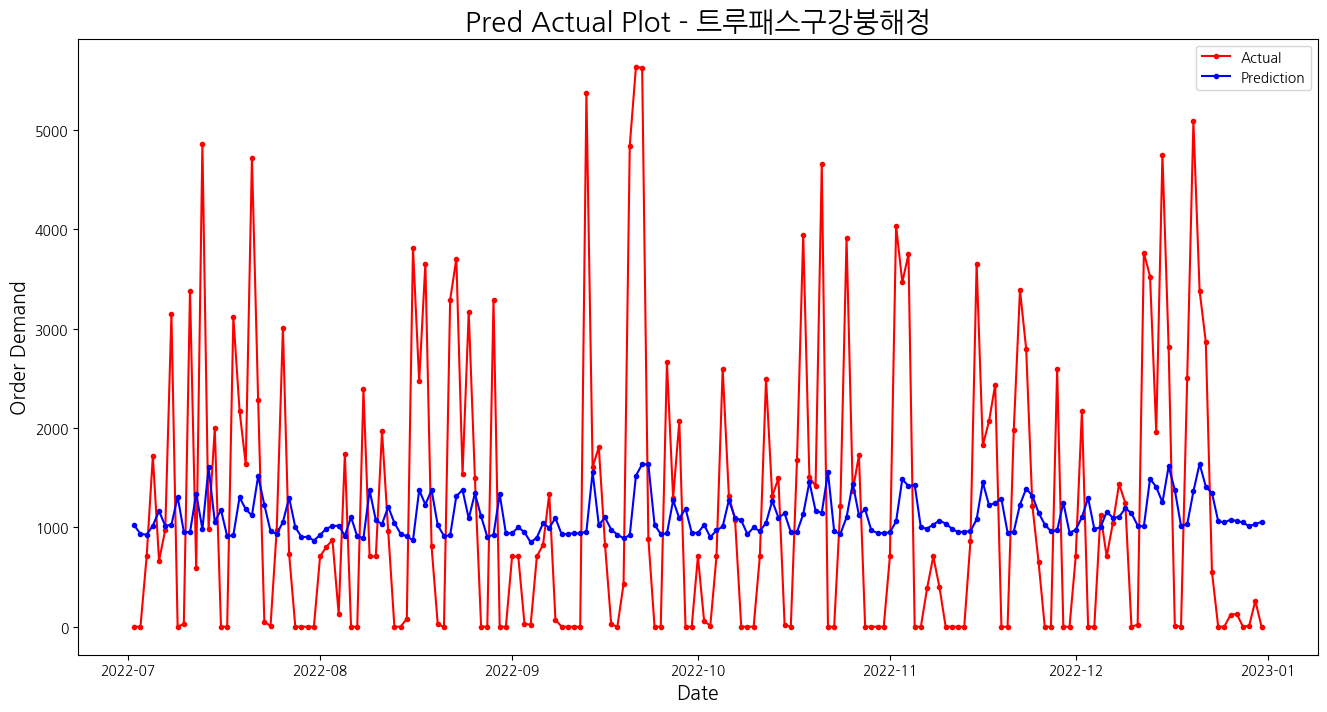

실행 시간: 0.20 분


In [13]:
for product in df['Product'].unique():
    print("==================================")
    print(f"========== { product } ==========")
    print("==================================")
    execute_single_LSTM(product)